In [1]:
import pickle
import torch
import numpy as np
from network.models import VP_EMOTION_LABELS
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
import jiwer

/data1/nmehlman/miniconda3/envs/priv-codec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data1/nmehlman/miniconda3/envs/priv-codec/lib/python3.9/site-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()


# Emotion

In [ ]:
# Load data
data_encodec_msp = pickle.load(open('/data1/nmehlman/logs/priv-codec/benchmarking/emotion/encodec-msp_podcast.pkl', 'rb'))
data_encodec_expresso = pickle.load(open('/data1/nmehlman/logs/priv-codec/benchmarking/emotion/encodec-expresso.pkl', 'rb'))
data_hificodec_msp = pickle.load(open('/data1/nmehlman/logs/priv-codec/benchmarking/emotion/hificodec-msp_podcast.pkl', 'rb'))
data_hificodec_expresso = pickle.load(open('/data1/nmehlman/logs/priv-codec/benchmarking/emotion/hificodec-expresso.pkl', 'rb'))
data_bigcodec_msp = pickle.load(open('/data1/nmehlman/logs/priv-codec/benchmarking/emotion/bigcodec-msp_podcast.pkl', 'rb'))
data_bigcodec_expresso = pickle.load(open('/data1/nmehlman/logs/priv-codec/benchmarking/emotion/bigcodec-expresso.pkl', 'rb'))

## Plot F1 and Confusion Matrix

In [ ]:
f1_scores = {}
cm = {}
for data, name in zip(
    [data_encodec_msp, data_encodec_expresso, data_hificodec_msp, data_hificodec_expresso, data_bigcodec_msp, data_bigcodec_expresso], 
    ['Encodec [MSP-Podcast]', 'Encodec [Expresso]', 'HifiCodec [MSP-Podcast]', 'HifiCodec [Expresso]', 'BigCodec [MSP-Podcast]', 'BigCodec [Expresso]']):

    y_true = data['true_labels'].cpu().numpy()
    y_pred_raw = data['preds_raw'].argmax(axis=1).cpu().numpy()
    y_pred_recon = data['preds_recon'].argmax(axis=1).cpu().numpy()

    # compute macro F1 (use 'weighted' or 'micro' if you prefer a different aggregation)
    f1_baseline = f1_score(y_true, y_pred_raw, average='macro', zero_division=0)
    f1_recon = f1_score(y_true, y_pred_recon, average='macro', zero_division=0)

    f1_scores[name] = {'raw': f1_baseline, 'recon': f1_recon}

    # keep the same variable names used later; store as torch tensors so .item() works
    acc_baseline = torch.tensor(f1_baseline)
    acc_recon = torch.tensor(f1_recon)

    # Confusion matrices side-by-side
    cm_raw = confusion_matrix(
        data['true_labels'].cpu().numpy(),
        data['preds_raw'].argmax(dim=1).cpu().numpy(),
        normalize='true'
    )
    cm_recon = confusion_matrix(
        data['true_labels'].cpu().numpy(),
        data['preds_recon'].argmax(dim=1).cpu().numpy(),
        normalize='true'
    )

    cm[name] = {'raw': cm_raw, 'recon': cm_recon}

    fig, axs = plt.subplots(1, 2, figsize=(15, 6.5))
    im0 = axs[0].imshow(cm_raw, interpolation='nearest', cmap=plt.cm.Blues)
    axs[0].set_xticks(np.arange(len(VP_EMOTION_LABELS)))
    axs[0].set_xticklabels(VP_EMOTION_LABELS, rotation=45, ha='right')
    axs[0].set_yticks(np.arange(len(VP_EMOTION_LABELS)))
    axs[0].set_yticklabels(VP_EMOTION_LABELS)
    axs[0].set_ylabel('True', fontsize=16)
    axs[0].set_xlabel('Predicted', fontsize=16)
    axs[0].set_title('Raw Speech [F1 = {:.2f}%]'.format(f1_baseline * 100))
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(cm_recon, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1].set_xticks(np.arange(len(VP_EMOTION_LABELS)))
    axs[1].set_xticklabels(VP_EMOTION_LABELS, rotation=45, ha='right')
    axs[1].set_yticks(np.arange(len(VP_EMOTION_LABELS)))
    axs[1].set_yticklabels(VP_EMOTION_LABELS)
    axs[1].set_ylabel('True', fontsize=16)
    axs[1].set_xlabel('Predicted', fontsize=16)
    axs[1].set_title('Reconstructed Speech [F1 = {:.2f}%]'.format(f1_recon * 100))
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    plt.suptitle(f"SER on {name}", fontsize=20)
    plt.tight_layout()
    plt.show()

## Make Before-After Confusion Matrix

In [ ]:
# Create confusion matrices comparing raw vs reconstructed predictions
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, (model, dataset) in enumerate([(m, d) for m in models for d in datasets]):
    name = f"{model} [{dataset}]"
    data = data_dict[model][dataset]
    
    y_pred_raw = data['preds_raw'].argmax(axis=1).cpu().numpy()
    y_pred_recon = data['preds_recon'].argmax(axis=1).cpu().numpy()
    
    # Confusion matrix: raw predictions vs reconstructed predictions
    cm_before_after = confusion_matrix(y_pred_raw, y_pred_recon, normalize='true')
    
    ax = axes[idx]
    im = ax.imshow(cm_before_after, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(len(VP_EMOTION_LABELS)))
    ax.set_xticklabels(VP_EMOTION_LABELS, rotation=45, ha='right', fontsize=10)
    ax.set_yticks(np.arange(len(VP_EMOTION_LABELS)))
    ax.set_yticklabels(VP_EMOTION_LABELS, fontsize=10)
    ax.set_ylabel('Raw Predictions', fontsize=12)
    ax.set_xlabel('Reconstructed Predictions', fontsize=12)
    ax.set_title(f'{name}', fontsize=13)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Prediction Consistency: Raw vs Reconstructed Speech', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


## Plot Before and After F1 Scores

In [ ]:
import pandas as pd

# Prepare data for plotting
plot_data = []
for name, scores in f1_scores.items():
    plot_data.append({'Model': name, 'Type': 'Raw', 'F1 Score': scores['raw']})
    plot_data.append({'Model': name, 'Type': 'Reconstructed', 'F1 Score': scores['recon']})

df_plot = pd.DataFrame(plot_data)

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(f1_scores))
width = 0.35

raw_scores = [scores['raw'] for scores in f1_scores.values()]
recon_scores = [scores['recon'] for scores in f1_scores.values()]

bars1 = ax.bar(x - width/2, raw_scores, width, label='Raw', alpha=0.8)
bars2 = ax.bar(x + width/2, recon_scores, width, label='Reconstructed', alpha=0.8)

ax.set_xlabel('Model and Dataset', fontsize=14)
ax.set_ylabel('F1 Score (Macro)', fontsize=14)
ax.set_title('Emotion Recognition F1 Scores: Raw vs Reconstructed Speech', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(f1_scores.keys(), rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Plot Before and After For Each Emotion

In [ ]:
# Create a 2x3 grid for all experiments
fig, axes = plt.subplots(3, 2, figsize=(15, 16))
axes = axes.flatten()

for idx, exp_name in enumerate(cm):
    
    exp_results = cm[exp_name]
    raw = exp_results['raw']
    recon = exp_results['recon']
    
    results = {}
    for i in range(len(raw)):
        
        emotion = VP_EMOTION_LABELS[i]
        
        if not np.any(raw[i]):
            continue
        
        emo_acc_raw = raw[i][i]
        emo_acc_recon = recon[i][i]

        results[emotion] = {
            'raw': emo_acc_raw,
            'recon': emo_acc_recon
        }

    x = np.arange(len(results))
    width = 0.35

    raw_scores = [scores['raw'] for scores in results.values()]
    recon_scores = [scores['recon'] for scores in results.values()]

    ax = axes[idx]
    bars1 = ax.bar(x - width/2, raw_scores, width, label='Raw', alpha=0.8)
    bars2 = ax.bar(x + width/2, recon_scores, width, label='Reconstructed', alpha=0.8)

    ax.set_xlabel('Emotion', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'{exp_name}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(results.keys(), rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)

plt.suptitle('Emotion Recognition Accuracy: Raw vs Reconstructed Speech', fontsize=18, y=0.995)
plt.tight_layout()
plt.show()


# Masked Emotions

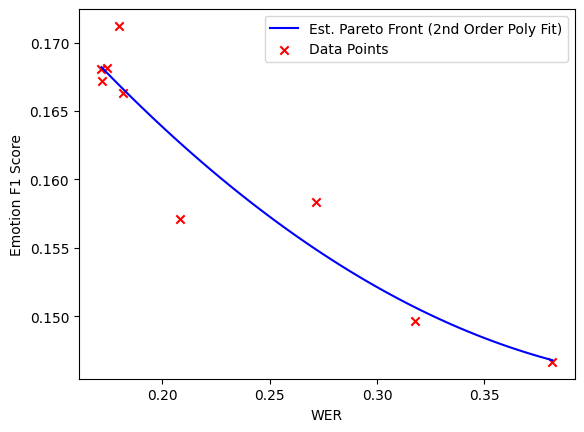

In [8]:
from cProfile import label


wer = []
f1 = []

for sigma in [0, 1, 5, 10, 20, 30, 75, 100, 125]:

    data_path = f'/data1/nmehlman/logs/priv-codec/informed-noise-masking/expresso/encodec/encodec-expresso-sigma={sigma}.pkl'

    data = pickle.load(open(data_path, 'rb'))

    y_true = data['true_emotion_labels'].cpu().numpy()
    y_pred_raw = data['emotion_preds_raw'].argmax(axis=1).cpu().numpy()
    y_pred_recon = data['emotion_preds_recon'].argmax(axis=1).cpu().numpy()

    # compute macro F1 (use 'weighted' or 'micro' if you prefer a different aggregation)
    f1_raw = f1_score(y_true, y_pred_raw, average='macro', zero_division=0)
    f1_recon = f1_score(y_true, y_pred_recon, average='macro', zero_division=0)

    transform = jiwer.Compose([
        jiwer.ToLowerCase(),
        jiwer.RemovePunctuation(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.ReduceToListOfListOfWords(),
    ])

    wer_raw = []
    for ref, hyp in zip(data['true_transcripts'], data["transcriptions_raw"]):
        _wer = jiwer.wer(ref, hyp, reference_transform=transform, hypothesis_transform=transform)
        if _wer > 2:
            continue # exclude samples with WER > 200%
        wer_raw.append(_wer)

    wer_recon = []
    for ref, hyp in zip(data['true_transcripts'], data["transcriptions_recon"]):
        _wer = jiwer.wer(ref, hyp, reference_transform=transform, hypothesis_transform=transform)
        if _wer > 2:
            continue # exclude samples with WER > 200%
        wer_recon.append(_wer)

    wer.append(np.mean(wer_recon))
    f1.append(f1_recon)

# Fit a 2nd order polynomial to WER vs F1 scores
coeffs = np.polyfit(wer, f1, 2)
poly = np.poly1d(coeffs)
wer_smooth = np.linspace(min(wer), max(wer), 100)
f1_smooth = poly(wer_smooth)

plt.plot(wer_smooth, f1_smooth, 'b-', label='Est. Pareto Front (2nd Order Poly Fit)')

plt.scatter(wer, f1, marker='x', color='red', label='Data Points')
plt.xlabel('WER')
plt.ylabel('Emotion F1 Score')
plt.legend()
plt.show()